In [1]:
import sys
sys.path.append('..')

In [2]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from myutils.matplotlib import matplotlib_seaborn_style, matplotlib_latex

from src.missing_values import impute_average
from src.pca import ImputePCA

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
figures_dir = Path('../data/report_figures')
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [5]:
# all_dates = np.arange(data['date'].min(), data['date'].max() + timedelta(days=1), timedelta(days=1))
all_dates = np.arange(datetime(2021, 5, 12), datetime(2021, 7, 7), timedelta(days=1))

In [6]:
trains = ['760А-C2', '768А-C2']
days = [2, 4, 7]

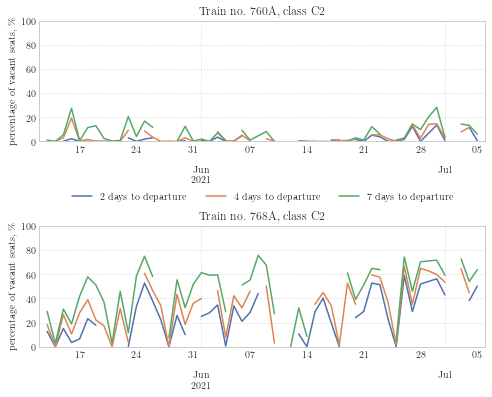

In [7]:
fig, axes = plt.subplots(nrows=len(trains))
fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, day in enumerate(days):
        ts = data[(data['train'] == train) & (data['days'] == day)]\
            .set_index('date')['places_frac'].reindex(all_dates) * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=f'{day} days to departure')
        
    ax.set_xlabel(None)
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35))

plt.savefig(figures_dir / 'seat_dynamics_dates.pdf', transparent=True, bbox_inches='tight')

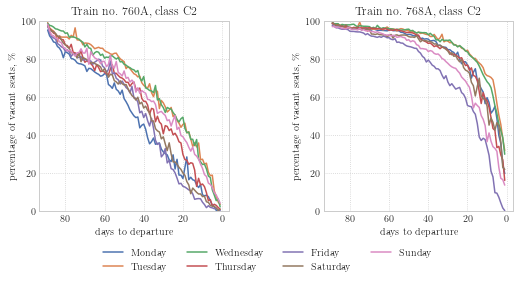

In [8]:
fig, axes = plt.subplots(ncols=len(trains))
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, weekday in weekdays.items():
        ts = data[(data['train'] == train) & (data['day_name'] == weekday)]\
            .groupby('days')['places_frac'].mean() * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=weekday)
        
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=4, bbox_to_anchor=(1.2, -0.15))

plt.savefig(figures_dir / 'seat_dynamics_days.pdf', transparent=True, bbox_inches='tight')

In [9]:
data_ = data[(data['train'] == '768А-C2') & (data['days'] <= 30)]\
    .pivot(index='date', columns='days', values='places_frac')

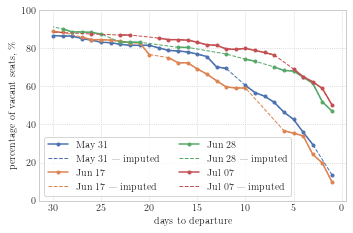

In [10]:
idx = [34, 50, 61, 68]

plt.figure(figsize=(5.5, 3.5))

for i, j in enumerate(idx):
    ts = data_.iloc[j] * 100
    ts_imp = pd.Series(impute_average(ts.values, lim=(0, 100)), index=ts.index)
    
    color = f'C{i}'
    date = data_.index[j].strftime('%b %d')
    
    ts.plot(c=color, marker='.', label=f'{date}')
    ts_imp.plot(c=color, ls='dashed', lw=1, label=f'{date} — imputed')
    
plt.legend(ncol=2, frameon=True)
plt.ylim(0, 100)

plt.gca().invert_xaxis()
plt.xlabel('days to departure')
plt.ylabel('percentage of vacant seats, \\%')

plt.savefig(figures_dir / 'imputation.pdf', transparent=True, bbox_inches='tight')

In [69]:
a = pd.read_csv('../data/model_analysis/principal_components.csv', index_col=0)
v = pd.read_csv('../data/model_analysis/eigenvectors.csv', index_col=0)
mu = pd.read_csv('../data/model_analysis/means.csv', index_col=0)

v.columns = v.columns.astype(int)
mu.columns = mu.columns.astype(int)

a.shape, v.shape, mu.shape

((103, 94), (94, 30), (94, 30))

In [70]:
x = np.hstack([v.values, mu.values])

x -= x.mean(axis=0)
x /= x.std(axis=0, ddof=1)

# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

x.shape

(94, 60)

In [71]:
pca = ImputePCA()

pcs = pca.fit_predict(x)

pca.explained_variance_ratio[:10]

array([0.75154283, 0.93560115, 0.97331484, 0.98944478, 0.9951251 ,
       0.99661639, 0.99757525, 0.99814447, 0.99856399, 0.99892106])

In [72]:
pcs = pcs[:, :2]

pcs.shape

(94, 2)

In [73]:
ox = np.linspace(pcs[:, 0].min(), pcs[:, 0].max(), 5)
idx = np.abs(pcs[:, [0]] - ox).argmin(axis=0)
trains = v.index[idx]

trains

Index(['760А-B2', '769А-B2', '767А-B1', '779А-C1', '755А-B1'], dtype='object', name='train')

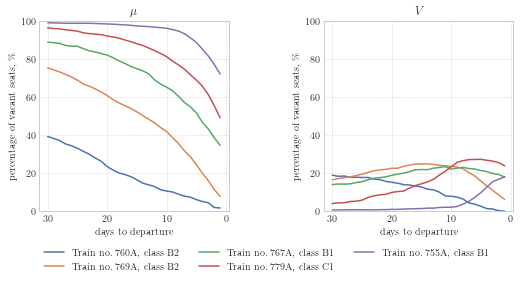

In [122]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for train in trains:
    num, cls = train.split('-')
    label = f'Train no. {num}, class {cls}'
    
    mui = mu.loc[train] * 100
    mui.plot(ax=axes[0], label=label)

    vi = v.loc[train] * 100
    vi.plot(ax=axes[1])
    
axes[0].set_title('$\\mu$')
axes[1].set_title('$V$')

axes[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(1.2, -0.15))
    
for ax in axes:
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    
plt.savefig(figures_dir / 'mu_v_examples.pdf', transparent=True, bbox_inches='tight')

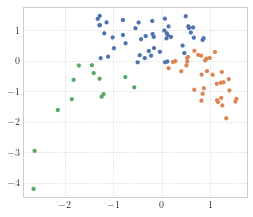

In [121]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=0).fit(pcs)
clusters = kmeans.predict(pcs)

plt.figure(figsize=(4, 3.5))

colors = [f'C{i}' for i in clusters]
plt.scatter(*pcs.T, color=colors, s=10)

plt.savefig(figures_dir / 'mu_v_projections.pdf', transparent=True, bbox_inches='tight')

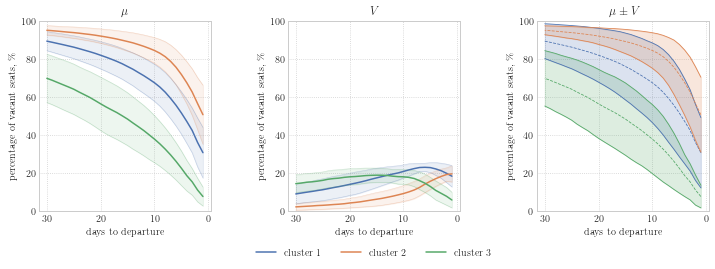

In [118]:
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(12, 3.5)
fig.subplots_adjust(wspace=0.45)

for i in np.unique(clusters):
    mask = clusters == i
    color = f'C{i}'

    ax = axes[0]
    
    mui = mu.iloc[mask] * 100
    mui_mean = mui.mean(axis=0)
    mui_std = mui.std(axis=0)
    
    ax.plot(mui_mean, c=color)
    
    lower = mui_mean - mui_std
    upper = mui_mean + mui_std
    ax.plot(lower, lw=0.5, alpha=0.3, c=color)
    ax.plot(upper, lw=0.5, alpha=0.3, c=color)
    ax.fill_between(mui_mean.index, lower, upper, alpha=0.1, color=color)
    
    ax = axes[1]
    
    vi = v.iloc[mask] * 100
    vi_mean = vi.mean(axis=0)
    vi_std = vi.std(axis=0)
    
    ax.plot(vi_mean, c=color, label=f'cluster {i + 1}')
    
    lower = vi_mean - vi_std
    upper = vi_mean + vi_std
    ax.plot(lower, lw=0.5, alpha=0.3, c=color)
    ax.plot(upper, lw=0.5, alpha=0.3, c=color)
    ax.fill_between(vi_mean.index, lower, upper, alpha=0.1, color=color)
    
    ax = axes[2]
    
    ax.plot(mui_mean, c=color, ls='dashed', lw=0.8)
    
    lower = mui_mean - vi_mean
    upper = mui_mean + vi_mean
    ax.plot(lower, lw=0.8, c=color)
    ax.plot(upper, lw=0.8, c=color)
    ax.fill_between(vi_mean.index, lower, upper, alpha=0.2, color=color)
    

axes[0].set_title('$\\mu$')
axes[1].set_title('$V$')
axes[2].set_title('$\\mu \\pm V$')
    
for ax in axes:
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, \\%')
    ax.set_ylim(0, 100)
    

axes[1].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.15))

plt.savefig(figures_dir / 'mu_v_clusters.pdf', transparent=True, bbox_inches='tight')